###### Bayesian Outlier Modeling 
## For N-of-1 Outlier Analysis of TCGA against Normal Sets

Model outliers using a linear combination of approximations. Each background dataset, $X_i$, for each gene $j$, contributes a posterior distribution of expression $y_{i,j}$ to a linear model that learns the vector of $\beta$ weights corresponding to each background comparison distribution to model an $n$-of-1 tumor sample's distribution $z_j$. Samples drawn from the posterior distribution $z_j$ are then compared to the n-of-1 sample.

# Inputs

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import rnaseq_lib3 as r

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_hdf('/mnt/data/Objects/tcga_gtex_tpm_norm_filt_centered.hd5')
gtex = df[df.label == 'gtex']
normal = df[df.label == 'tcga-normal']
tumor = df[df.label == 'tcga-tumor']

In [3]:
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]
len(drug_genes)

85

Subset by dataset

In [4]:
def plot_gene_dist(n_of_1, gene):
    plt.axvline(n_of_1[gene], label='n-of-1', color='red')
    sns.kdeplot(gtex[gene], label='gtex')
    sns.kdeplot(normal[gene], label='normal')
    sns.kdeplot(tumor[gene], label='tumor')    
    plt.title(gene);

# Build Model

In [13]:
def n_params(n_genes, n_datasets):
    return ((n_genes * n_datasets) * 4) + 1 + n_datasets + n_genes

In [8]:
def train_model(n_of_1, genes, datasets, n_samples=200, tune=1000):
    """
    n_of_1: tumor sample 
    genes: genes to learn
    datasets: datasets to include
    n_samples = Samples to generate
    """
    with pm.Model() as model:
        # Priors for gene expression
        hyper_shape = len(genes) * len(datasets)
        hyper_sigma = pm.InverseGamma('hyper_sigma', 1, shape=hyper_shape)
        hyper_mu = pm.Normal('hyper_mu', 3, hyper_sigma, shape=hyper_shape)
        
        # RVs for Gene expression
        # X is observed and Y isn't, but they share hyper priors
        X, Y = {}, {}
        i = 0
        for gene in genes:
            for name, dataset in datasets:
                key = f'{gene}-{name}'
                X[key] = pm.Normal(f'X-{key}', mu=hyper_mu[i], sd=np.sqrt(hyper_sigma[i]), observed=dataset[gene])
                Y[key] = pm.Normal(f'Y-{key}', mu=hyper_mu[i], sd=np.sqrt(hyper_sigma[i]))
        i += 1
        
        # Sigma prior for Z, shared across all genes
        sigma = pm.InverseGamma('sigma', 1)
        
        # Priors for linear model
        alpha = pm.Normal('alpha', 0, 10)
        beta = pm.Normal('beta', 0, 10, shape=len(datasets))
        
        # Define linear model for each gene
        mu = {}
        for gene in genes:
            mu[gene] = alpha
            for j, (name, _) in enumerate(datasets):
                mu[gene] += Y[f'{gene}-{name}'] * beta[j]
        
        # Posterior distribution
        z = {}
        for i, gene in enumerate(genes):
            z[gene] = pm.Laplace(f'z-{gene}', mu=mu[gene], b=sigma, observed=n_of_1[gene])
            
        # Calculate trace
        trace = pm.sample(n_samples, 
                          tune=tune, 
                          nuts_kwargs={'target_accept': 0.95},
                          njobs=12)
    return model, trace

## Train

Select an n_of_1 sample and train

In [5]:
n_of_1 = tumor.loc['TCGA-BH-A0DS-01']

Find an example gene that is not an outlier

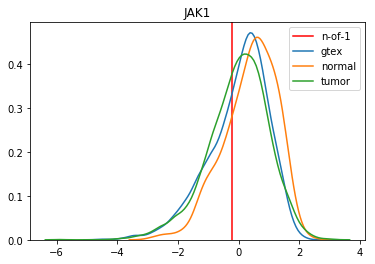

In [6]:
plot_gene_dist(n_of_1, gene='JAK1')

Find an example outlier gene

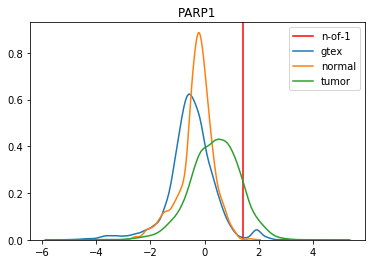

In [7]:
plot_gene_dist(n_of_1, gene='PARP1')

Train n-of-1 on drug genes

In [29]:
genes = np.random.choice(df.columns[5:], 200, replace=False)

In [30]:
#datasets = [('gtex', gtex), ('normal', normal)]
breast = normal[normal.tissue == 'Breast']

In [31]:
model, trace = train_model(n_of_1, drug_genes, datasets=[('Breast', breast)])

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [beta, alpha, sigma, Y-PARP1-Breast, Y-AURKC-Breast, Y-AURKB-Breast, Y-AURKA-Breast, Y-MS4A1-Breast, Y-BTK-Breast, Y-HSP90B1-Breast, Y-HSP90AB3P-Breast, Y-HSP90AB1-Breast, Y-HSP90AA1-Breast, Y-MDM2-Breast, Y-BCL6-Breast, Y-BCL2-Breast, Y-SMO-Breast, Y-GLI1-Breast, Y-PTCH1-Breast, Y-MAP2K2-Breast, Y-MAP2K1-Breast, Y-ARAF-Breast, Y-RAF1-Breast, Y-BRAF-Breast, Y-HRAS-Breast, Y-KRAS-Breast, Y-NRAS-Breast, Y-DEPTOR-Breast, Y-MLST8-Breast, Y-RPTOR-Breast, Y-MTOR-Breast, Y-TSC2-Breast, Y-TSC1-Breast, Y-AKT3-Breast, Y-AKT1-Breast, Y-PIK3C3-Breast, Y-PIK3C2G-Breast, Y-PIK3C2B-Breast, Y-PIK3C2A-Breast, Y-PIK3R6-Breast, Y-PIK3R5-Breast, Y-PIK3R4-Breast, Y-PIK3R3-Breast, Y-PIK3R2-Breast, Y-PIK3R1-Breast, Y-PIK3CD-Breast, Y-PIK3CG-Breast, Y-PIK3CB-Breast, Y-PIK3CA-Breast, Y-CDK2-Breast, Y-CCNE1-Breast, Y-CCND3-Breast, Y-CCND2-Breast, Y-CCND1-Breas

# Traceplot

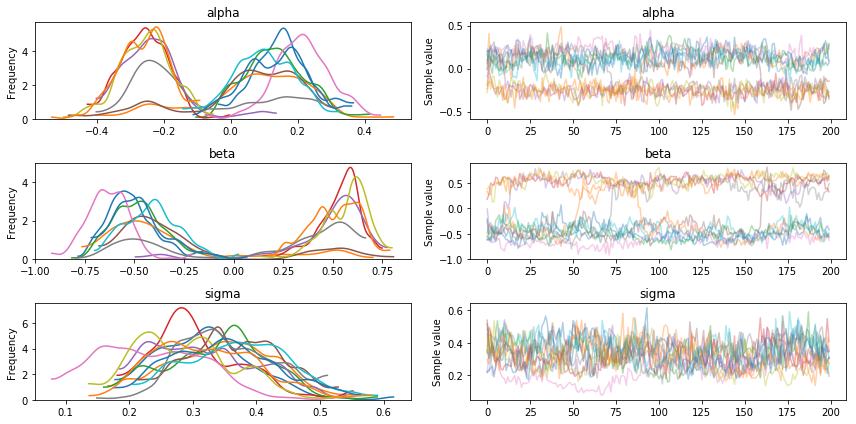

In [32]:
pm.traceplot(trace, varnames=['alpha', 'beta', 'sigma']);

Traceplots appear to have not converged.

## Parameter KDEs

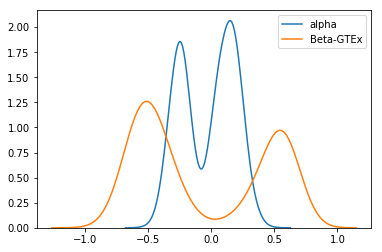

In [33]:
sns.kdeplot(trace['alpha'], label='alpha')
sns.kdeplot(trace['beta'][:,0], label='Beta-GTEx');
#sns.kdeplot(trace['beta'][:,1], label='Beta-Normal');